# Futures vs Cash CTD comparison

In this notebook we'll examine all of the futures return vs the synthetic CTD returns. For the most part the interest relies solely in generating a reasonable time series for CTD cash Treasuries. Transactions costs at this point will be ignored.

## Packages

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Accessing Data

In [6]:
sys.path.append(r"/Users/diegoalvarez/Desktop/CashTreasuries/root/src")
from SyntheticCTDReturns import SyntheticCTD

In [7]:
def combine_data() -> pd.DataFrame: 

    futures_path = r"/Users/diegoalvarez/Desktop/BBGFuturesManager/data/PXFront"
    
    df_tsy = SyntheticCTD().get_synthetic_rtn_calc()
    
    paths = [
        os.path.join(futures_path, ticker + ".parquet") 
        for ticker in SyntheticCTD().tsy_tickers.keys()]
    
    df_namer = (pd.DataFrame().from_dict(
        data    = SyntheticCTD().tsy_tickers,
        orient  = "index", 
        columns = ["yield_tenor"]).
        reset_index().
        rename(columns = {"index": "security"}).
        assign(
            yield_tenor = lambda x: "DGS" + x.yield_tenor.astype(str),
            security    = lambda x: x.security + "1"))
    
    df_combined = (pd.read_parquet(
        path = paths, engine = "pyarrow").
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        merge(right = df_namer, how = "inner", on = ["security"]).
        merge(right = df_tsy, how = "inner", on = ["date", "yield_tenor"]))

    return df_combined

df_combined = combine_data()

In [8]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date")
        [["date", "PX_LAST", "bnd_rtn"]].
        assign(
            fut_rtn = lambda x: np.cumprod(1 + x.PX_LAST.pct_change()) - 1,
            ctd_rtn = lambda x: x.bnd_rtn.cumsum()).
        drop(columns = ["PX_LAST", "bnd_rtn"]))

    return df_out

def get_rtn(df_combined: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_combined.groupby(
        "yield_tenor").
        apply(_get_rtn, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        set_index("date"))

    return df_tmp

df_rtn = get_rtn(df_combined)

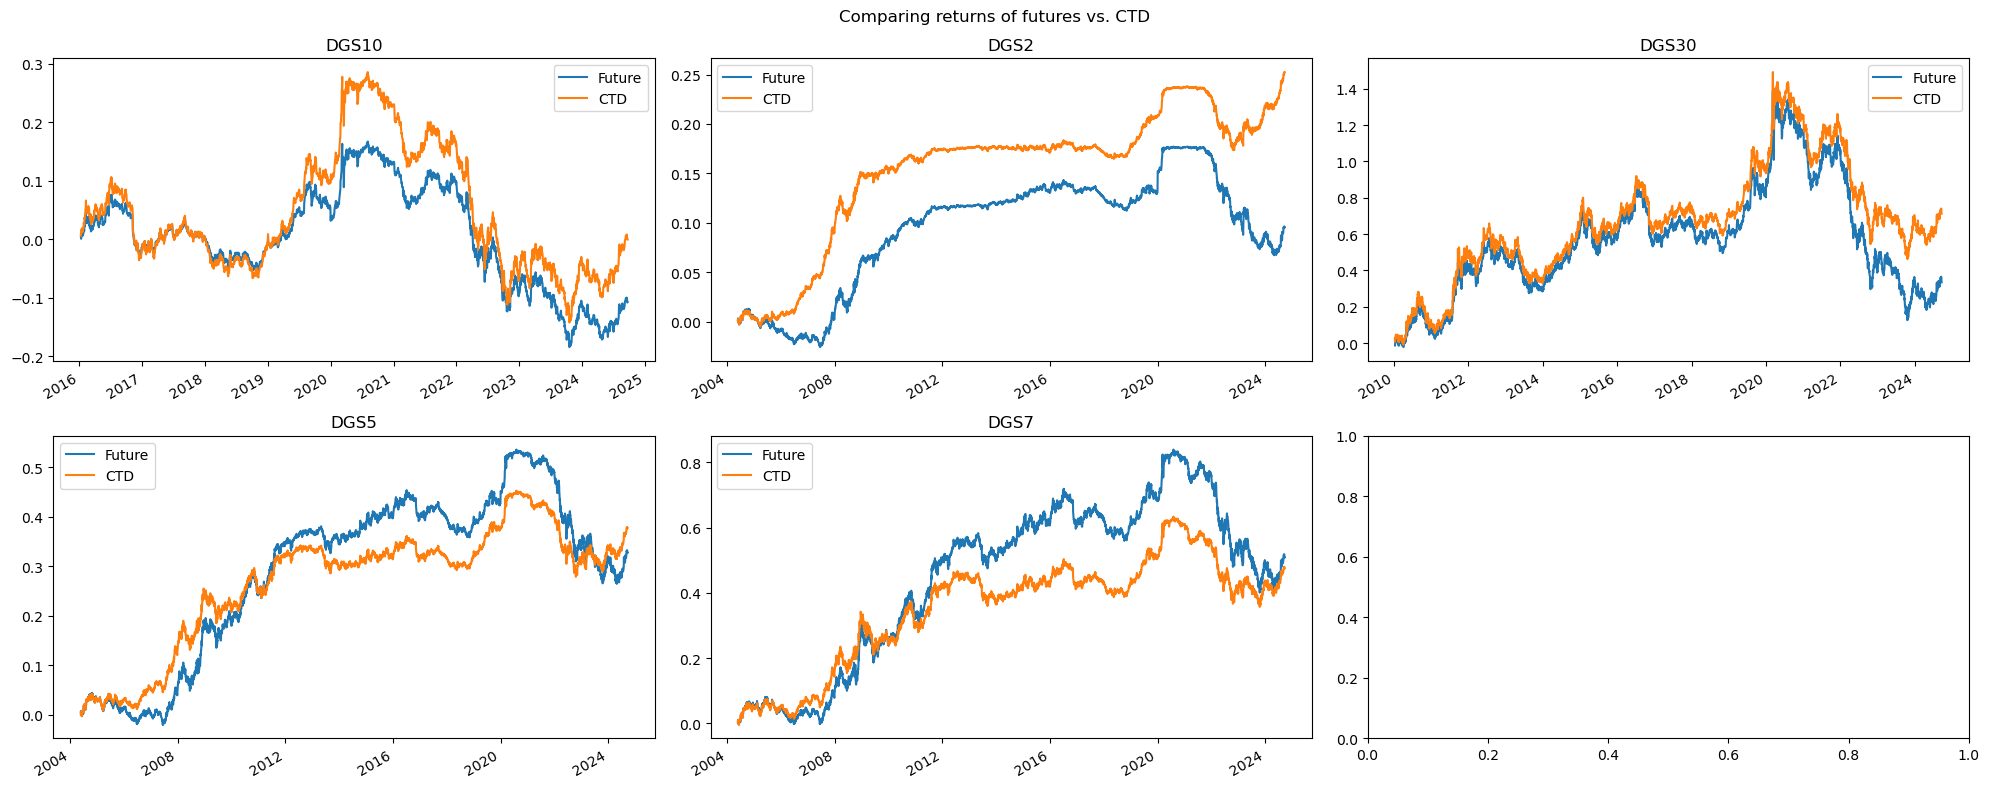

In [9]:
def compare_rtn(df_rtn: pd.DataFrame) -> plt.Figure: 

    tenors    = df_rtn.yield_tenor.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (20,8))
    
    for tenor, ax in zip(tenors, axes.flatten()): 
    
        (df_rtn.query(
            "yield_tenor == @tenor").
            drop(columns = ["yield_tenor"]).
            rename(columns = {
                "fut_rtn": "Future",
                "ctd_rtn": "CTD"}).
            plot(
                title  = tenor,
                ax     = ax,
                xlabel = ""))
    
    fig.suptitle("Comparing returns of futures vs. CTD")
    plt.tight_layout()

compare_rtn(df_rtn)

In [20]:
def get_etf_rtn(df_combined: pd.DataFrame) -> pd.DataFrame: 

    yf_tickers = {
        "DGS2" : "SHY",
        "DGS10": "IEF",
        "DGS5" : "IEI",
        "DGS30": "TLT",
        "DSG7" : "IEF"}
    
    df_namer = (pd.DataFrame.from_dict(
        data = yf_tickers,
        orient = "index",
        columns = ["ticker"]).
        reset_index().
        rename(columns = {"index": "yield_tenor"}))
    
    tickers = df_namer.ticker.drop_duplicates().to_list()
    
    df_daily_rtn = (df_combined[
        ["date", "yield_tenor", "PX_LAST", "bnd_rtn"]].
        assign(date = lambda x: pd.to_datetime(x.date)))
    
    df_etf  = (yf.download(
        tickers = tickers)
        ["Adj Close"].
        pct_change().
        reset_index().
        melt(id_vars = "Date").
        rename(columns = {
            "Ticker": "ticker",
            "Date"  : "date",
            "value" : "etf_rtn"}).
        merge(df_namer, how = "inner", on = ["ticker"]).
        dropna().
        assign(date = lambda x: pd.to_datetime(x.date)).
        merge(right = df_combined, how = "inner", on = ["date", "yield_tenor"]))

    return df_etf

df_etf = get_etf_rtn(df_combined)

[*********************100%***********************]  4 of 4 completed


In [22]:
def _get_etf_rtn(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(
            etf_rtn = lambda x: np.cumprod(1 + x.etf_rtn) - 1,
            fut_rtn = lambda x: np.cumprod(1 + x.PX_LAST.pct_change()) - 1,
            bnd_rtn = lambda x: x.bnd_rtn.cumsum()))

    return df_out

def get_etf_rtn(df_etf: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_etf.groupby(
        "ticker").
        apply(_get_etf_rtn, include_groups = False).
        reset_index(drop = True))

    return df_out

df_etf_rtn = get_etf_rtn(df_etf)

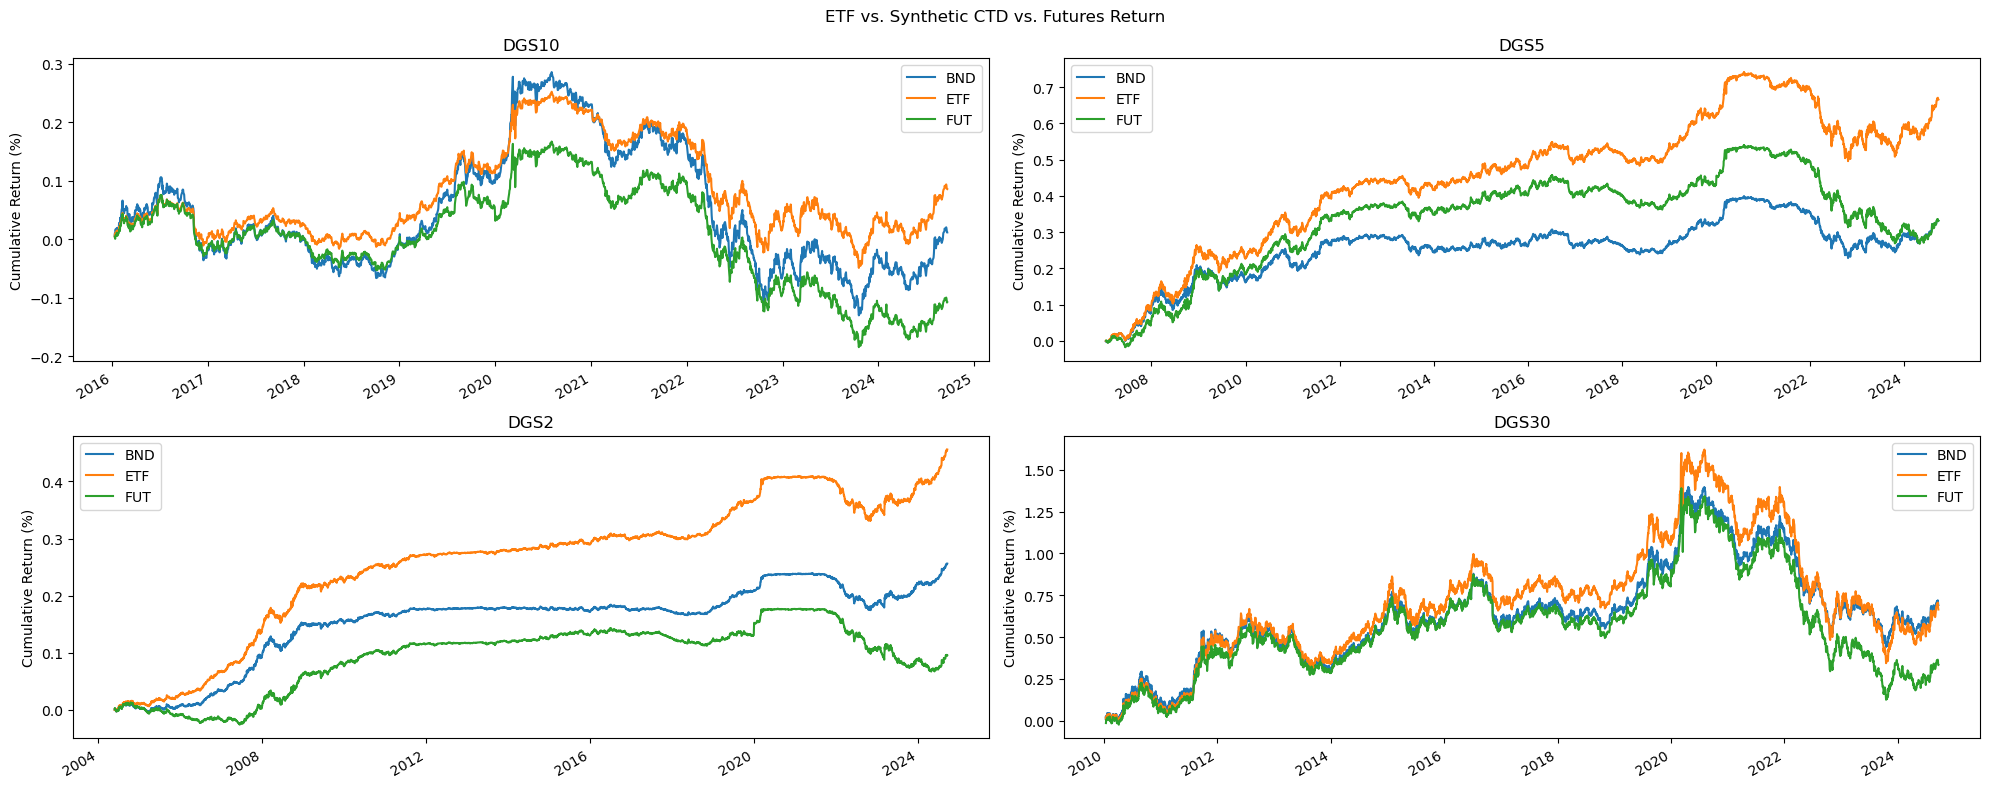

In [24]:
def plot_etf_return(df_etf_rtn: pd.DataFrame) -> pd.DataFrame:

    tenors = df_etf_rtn.yield_tenor.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(tenors) // 2, nrows = len(tenors) // 2, figsize = (20,8))
    
    for tenor, ax in zip(tenors, axes.flatten()):
    
        (df_etf_rtn.query(
            "yield_tenor == @tenor")
            [["date", "etf_rtn", "fut_rtn", "bnd_rtn"]].
            melt(id_vars = "date").
            assign(variable = lambda x: x.variable.str.split("_").str[0].str.upper()).
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "value").
            plot(
                ax     = ax, 
                title  = tenor,
                xlabel = "",
                ylabel = "Cumulative Return (%)"))
    
    fig.suptitle("ETF vs. Synthetic CTD vs. Futures Return")
    plt.tight_layout()

plot_etf_return(df_etf_rtn)